# Использование примера Keras для идентификации пользователя

### Настройка

In [10]:
# !pip3 install ffmpeg
import os
import shutil
import numpy as np

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

### Перемещение аудиодорожек в нужные папки

In [26]:
file_source = 'cv-corpus-7.0-2021-07-21/ru/wav_clips/full'
file_destination = 'data/audio/female'

test_male = pd.read_csv("male.csv")
for index in files:
    shutil.move(f"{file_source}/{index}", file_destination)

In [29]:
fe_dirname = 'data/audio/female'
ma_dirname = 'data/audio/male'
fe_files = os.listdir(fe_dirname)
ma_files = os.listdir(ma_dirname)
for index in range(473):
    os.remove(f'{fe_dirname}/{fe_files[index]}')

fe_files = os.listdir(fe_dirname)
ma_files = os.listdir(ma_dirname)



print(len(fe_files))
print(len(ma_files))


11279
11279


### Начало работы

In [65]:
DATASET_ROOT = "data"
TEST_DATASET_ROOT = "test_cut_audio"
# Percentage of samples to use for validation
VALID_SPLIT = 0.1


# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)
DATASET_TEST_PATH = TEST_DATASET_ROOT

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 30

In [8]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

### Подготовка шума

In [11]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 3 directories


### Перевод в 16 КГц

In [12]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

os.system(command)

# Split noise into chunks of 16000 each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


2022-05-19 21:26:10.339530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Генерация данных

In [76]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['male', 'female']
Processing speaker male
Processing speaker female
Found 22558 files belonging to 2 classes.
Using 20303 files for training.
Using 2255 files for validation.


### Подготовка тестового датасета

In [66]:
test_class_names = os.listdir(DATASET_TEST_PATH)
print("Our class names: {}".format(test_class_names,))
test_audio_paths = []
test_labels = []
for label, name in enumerate(test_class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_TEST_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    test_audio_paths += speaker_sample_paths
    test_labels += [label] * len(speaker_sample_paths)
print(
    "Found {} files belonging to {} classes.".format(len(test_audio_paths), len(test_class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

print("Using {} files for training.".format(len(test_audio_paths)))






# Creating dataset for testing
test_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

# Transform audio wave to the frequency domain using `audio_to_fft`
test_ds = test_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
# test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['male', 'female']
Processing speaker male
Processing speaker female
Found 3319 files belonging to 2 classes.
Using 3319 files for training.


In [ ]:
print(test_labels)

### Назначение модели

In [77]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["categorical_accuracy"]
)
# ,tf.keras.metrics.AUC(), tf.keras.metrics.AUC(curve = 'PR'), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()
# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "new_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_categorical_accuracy", save_best_only=True
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_127 (Conv1D)            (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation_91 (Activation)     (None, 8000, 16)     0           ['conv1d_127[0][0]']             
                                                                                                  
 conv1d_128 (Conv1D)            (None, 8000, 16)     784         ['activation_91[0][0]']          
                                                                                            

### Тренируем модель

In [81]:
history_1 = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    class_weight={0: 3, 1: 1},
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/30
159/159 [==============================] - 376s 2s/step - loss: 0.9621 - categorical_accuracy: 0.8163 - val_loss: 0.5144 - val_categorical_accuracy: 0.5911


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/30
159/159 [==============================] - 368s 2s/step - loss: 0.8322 - categorical_accuracy: 0.7155 - val_loss: 0.5590 - val_categorical_accuracy: 0.6452
Epoch 3/30
159/159 [==============================] - 361s 2s/step - loss: 0.7499 - categorical_accuracy: 0.6978 - val_loss: 0.4493 - val_categorical_accuracy: 0.6160
Epoch 4/30
159/159 [==============================] - 375s 2s/step - loss: 0.6592 - categorical_accuracy: 0.6790 - val_loss: 0.3443 - val_categorical_accuracy: 0.5583
Epoch 5/30
159/159 [==============================] - 367s 2s/step - loss: 0.6074 - categorical_accuracy: 0.6633 - val_loss: 0.3235 - val_categorical_accuracy: 0.5894
Epoch 6/30
159/159 [==============================] - 377s 2s/step - loss: 0.5702 - categorical_accuracy: 0.6507 - val_loss: 0.3059 - val_categorical_accuracy: 0.6009
Epoch 7/30
159/159 [==============================] - 366s 2s/step - loss: 0.5287 - categorical_accuracy: 0.6379 - val_loss: 0.3227 - val_categorical_accuracy: 0.614

In [72]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    class_weight={0: 2, 1: 1},
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/30
159/159 [==============================] - 375s 2s/step - loss: 0.3800 - categorical_accuracy: 0.5599 - val_loss: 0.1314 - val_categorical_accuracy: 0.5512
Epoch 2/30
159/159 [==============================] - 367s 2s/step - loss: 0.1902 - categorical_accuracy: 0.5216 - val_loss: 0.0894 - val_categorical_accuracy: 0.5020
Epoch 3/30
159/159 [==============================] - 362s 2s/step - loss: 0.1606 - categorical_accuracy: 0.5191 - val_loss: 0.1245 - val_categorical_accuracy: 0.4909
Epoch 4/30
159/159 [==============================] - 361s 2s/step - loss: 0.1378 - categorical_accuracy: 0.5172 - val_loss: 0.0806 - val_categorical_accuracy: 0.5246
Epoch 5/30
159/159 [==============================] - 344s 2s/step - loss: 0.1193 - categorical_accuracy: 0.5138 - val_loss: 0.0892 - val_categorical_accuracy: 0.5206
Epoch 6/30
159/159 [==============================] - 349s 2s/step - loss: 0.1186 - categorical_accuracy: 0.5147 - val_loss: 0.0789 - val_categorical_accuracy: 0.521

### Оценка на валидирующей выборке

In [13]:
print(model.evaluate(train_ds))

159/159 [==============================] - 108s 662ms/step - loss: 0.1904 - accuracy: 0.9127
[0.1904032975435257, 0.9127222299575806]


### Тестирование

In [ ]:
print(test_labels)
print(len(test_labels))

In [42]:
print(test_ds.take(1027))

<TakeDataset shapes: ((None, 8000, 1), (None,)), types: (tf.float32, tf.int32)>


In [67]:
y_pred = model.predict(test_ds)
probs = []
pred = []
true = []
for index in range(len(y_pred)):
    probs.append(np.max(y_pred[index]))
    pred.append(class_names[np.argmax(y_pred[index])])
    true.append(class_names[test_labels[index]])

for index in range(len(probs)):
    data = pd.DataFrame(zip([probs[index]],[pred[index]],[true[index]]), columns=['probability','predict','true'])
    data.to_csv(r"ker_cut_result.csv", mode = 'a', header=False, index=False)

In [37]:
print(y_pred)

[[0.8630892  0.13691084]
 [0.53704584 0.46295407]
 [0.52269906 0.47730097]
 ...
 [0.53592753 0.4640725 ]
 [0.5020996  0.49790046]
 [0.5085381  0.49146193]]


In [105]:
SAMPLES_TO_DISPLAY = len(test_audio_paths)

for test_audios, test_labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(test_audios)
    # Predict
    y_pred = model.predict(test_audios)
    # Take random samples
    rnd = np.empty(128, dtype = int)
    # rnd = np.random.randint(0, SAMPLES_TO_DISPLAY, SAMPLES_TO_DISPLAY)
    for i in range(127):
        rnd[i] = i
    # audios = audios.numpy()[rnd, :, :]
    test_labels = test_labels.numpy()[rnd]
    # print(f'inddex {y_pred}')
    y_prediction = np.max(y_pred, axis=-1)[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]
    
    
    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        data = pd.DataFrame(zip([y_prediction[index]],[class_names[y_pred[index]]],[class_names[test_labels[index]]]), columns=['probability','predict','true'])
        data.to_csv(r"ker_result.csv", mode = 'a', header=False, index=False)


IndexError: index 4575612391515166192 is out of bounds for axis 0 with size 128

In [68]:
print(len(test_audio_paths))

3319


# Перенос и обрезание данных

## Тестовые данные

### Мужские голоса

In [15]:
import librosa
import soundfile as sf

In [18]:
for root, dirs, files in os.walk("test_audio/female"):
  for file in files:
    audiofile = f"test_audio/female/{file}"
    audio, sr = librosa.load(audiofile, sr= 8000, mono=True)
    # print(audio.shape, sr)
    clips = librosa.effects.split(audio, top_db=10)
    # print(clips)
    wav_data = []
    for c in clips:
        print(c)
        data = audio[c[0]: c[1]]
        wav_data.extend(data)
    sf.write(f'test_cut_audio/female/{file}', wav_data, sr)

[ 9728 14336]
[14848 17920]
[20992 27136]
[27648 30208]
[31744 38400]
[ 8704 11776]
[12288 21504]
[ 6656 10240]
[1536 7168]
[ 8192 10752]
[6144 8192]
[ 8704 11776]
[12800 20480]
[24064 26624]
[27136 33280]
[34304 35328]
[35840 38912]
[47616 49664]
[55296 58368]
[   0 2048]
[ 9728 23040]
[24064 26112]
[12288 22528]
[ 5120 22016]
[ 4608 27648]
[28160 52224]
[54272 57344]
[58880 60928]
[63488 65536]
[ 4608 12800]
[ 6656 13824]
[18944 27648]
[29696 34816]
[37888 40448]
[ 6144 18432]
[19456 44032]
[47104 48640]
[ 5120 11776]
[14336 16384]
[16896 22016]
[24576 26112]
[10240 14848]
[15360 31232]
[32256 33792]
[37376 41472]
[42496 54272]
[56320 59904]
[ 5632 14848]
[ 6656 15360]
[16384 23040]
[23552 26112]
[27136 38912]
[ 7168 19968]
[23552 28160]
[28672 33280]
[36352 40960]
[42496 47616]
[ 7680 13824]
[14336 18944]
[19456 23040]
[ 2560 13824]
[14848 21504]
[ 4096 10240]
[11776 15360]
[15872 21504]
[22528 31232]
[32256 40448]
[ 5632 14336]
[15360 18432]
[20480 22016]
[23552 28672]
[29696 35328

# Интерпретация полученных из теста данных

### f мера и другие показатели

In [91]:
results = pd.read_csv("ker_full_result.csv")
tp = 0
fp = 0
fn = 0
tn = 0

for i, row in results.iterrows():
    if row['predict'] == 'male' and row['true'] == 'male':
        tp += 1
    if row['predict'] == 'male' and row['true'] == 'female':
        fp += 1
    if row['predict'] == 'female' and row['true'] == 'male':
        fn += 1
    if row['predict'] == 'female' and row['true'] == 'female':
        tn += 1

pre = tp/(tp + fp)
rec = tp/(tp + fn)
f1 = 2 * (pre * rec)/(pre + rec)

precision_male = tp/(tp + fn)
precision_female = tn/(tn + fp)

print(f"true positive: {tp}, \t false positive: {fp}, \t false negative: {fn}, \t, true negative: {tn} \nprecision = {pre}, \t recall = {rec}, \t f1 = {f1} \nТочность определения male: {precision_male}, \t female: {precision_female}")

true positive: 480, 	 false positive: 94, 	 false negative: 2284, 	, true negative: 461 
precision = 0.8362369337979094, 	 recall = 0.1736613603473227, 	 f1 = 0.28759736369083283 
Точность определения male: 0.1736613603473227, 	 female: 0.8306306306306306


### PR кривая

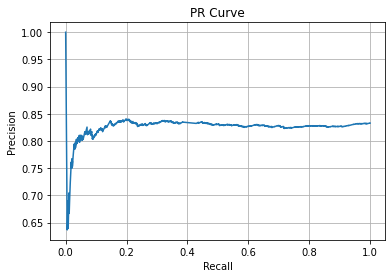

In [92]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import auc
import matplotlib.pyplot as plt
y = []
test = []
score = []
for i, row in results.iterrows():
    if row['true'] == 'male':
        if row['predict'] == 'male':
            y.append([1, row['probability']])
        else:
            y.append([1, 1 - row['probability']])
    else:
        if row['predict'] == 'male':
            y.append([0, row['probability']])
        else:
            y.append([0, 1 - row['probability']])

y.sort(reverse = True, key = lambda x: x[1])
for index in y:
    test.append(index[0])
    score.append(index[1])
precision, recall, _ = precision_recall_curve(test, score)
# auc = auc(precision, recall)
# print(y)

# display = PrecisionRecallDisplay.from_predictions(test, score, name="LinearSVC")
# _ = display.ax_.set_title("2-class Precision-Recall curve")


plt.figure()
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(recall,precision)
plt.show()

### ROC кривая

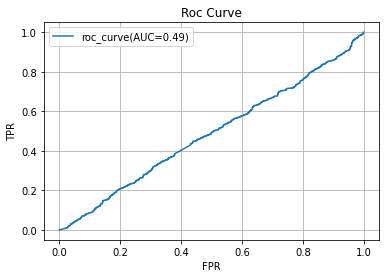

In [93]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test, score)
#print(fpr)
#print(tpr)
plt.figure()
plt.grid()
plt.title('Roc Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

auc=auc(fpr, tpr)#AUCCalculation
plt.plot(fpr,tpr,label='roc_curve(AUC=%0.2f)'%auc)
plt.legend()
plt.show()

### Гистограмма распределения вероятностей по полу

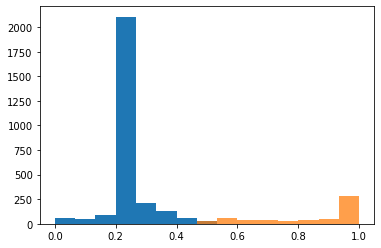

In [94]:
male_probs = []
female_probs = []
for i, row in results.iterrows():
    if row['predict'] == 'male':
        male_probs.append(row['probability'])
    else: 
        female_probs.append( 1 - row['probability'])
# print(female_probs)
# fig,ax1 = plt.subplots(figsize=(9,6))
# ax1.hist(female_probs,20,histtype='bar',alpha=0.75,cumulative=True,rwidth=0.8,stacked=True)


# plt.hist(male_probs, alpha=0.75, label='male')
# plt.hist(female_probs, alpha=0.75, label='female')
# plt.legend(loc='upper right')
# plt.show()

_, bins, _ = plt.hist(female_probs, range=[0, 1], bins=15, label='male')
_ = plt.hist(male_probs, bins=bins, alpha=0.75, label = 'female')
# ax1.set_title("Распределение вероятностей")  
# fig.subplots_adjust(hspace=0.4)  
# plt.show()

### Вывод прогресса lossa на обучении

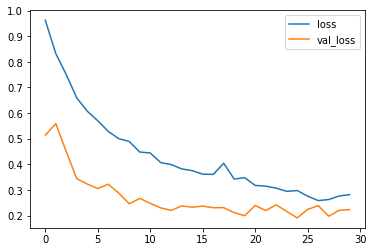

In [85]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
legend_list = ['loss', 'val_loss']
plt.legend(legend_list)

### Вывод прогресса accuracy на обучении

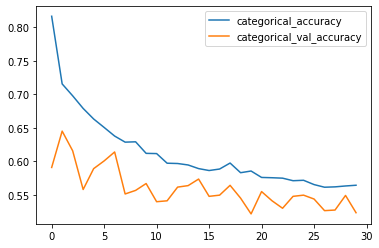

In [86]:
plt.plot(history_1.history['categorical_accuracy'])
plt.plot(history_1.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'categorical_val_accuracy'])